In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
from src.pre_process.V4.feature_add import FeatureAddition
from src.pre_process.V4.feature_duplicate import FeatureDuplication

In [3]:
BASE_PATH = r'C:\Users\com\Documents\GitHub\level2-competitiveds-recsys-06\data\etc'
data = pd.read_csv(os.path.join(BASE_PATH, 'v4_baek+recent+rank.csv'))
# train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
# test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

---

# data 확인

In [4]:
data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,has_high_school_within_1km,nearest_park_distance,nearest_park_within_500.0m,has_park_within_500.0m,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,1,498.618918,1,1,7683,29300,0,NaN,1.78,-0.07
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,1,498.618918,1,1,7683,29300,1,17000.0,1.26,-0.17
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,1,498.618918,1,1,7683,29300,2,23000.0,1.26,-0.17
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,1,169.839678,3,1,18366,58901,3,NaN,1.68,-0.10
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,0,382.401815,1,1,18369,58863,4,NaN,1.85,-0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,...,1,398.113485,1,1,6088,25360,150167,37000.0,3.62,-0.04
1951396,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,...,1,398.113485,1,1,6088,17911,150168,43000.0,3.59,-0.03
1951397,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,...,1,398.113485,1,1,6088,17911,150169,43000.0,3.59,-0.03
1951398,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,...,1,398.113485,1,1,6088,24128,150170,32500.0,3.59,-0.03


In [5]:
data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit', '_type', 'apt_idx', 'area', 'area_price', 'area_m2_price',
       'grid_id', 'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate']

---

# 추가 EDA

## contract_type one-hot encoding

In [4]:
# contract_type one-hot encoding
data = pd.get_dummies(data, columns=['contract_type'], prefix='contract')

In [5]:
data.drop(columns='contract_2', inplace=True)

In [6]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,nearest_park_within_500.0m,has_park_within_500.0m,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,1,1,7683,29300,0,NaN,1.78,-0.07,False,False
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,1,1,7683,29300,1,17000.0,1.26,-0.17,False,False
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,1,1,7683,29300,2,23000.0,1.26,-0.17,False,False
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,3,1,18366,58901,3,NaN,1.68,-0.10,False,False
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,1,1,18369,58863,4,NaN,1.85,-0.09,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,1,1,6088,25360,150167,37000.0,3.62,-0.04,True,False
1951396,150168,142.8738,202403,2,4,2010,37.528394,126.659398,14,NaN,...,1,1,6088,17911,150168,43000.0,3.59,-0.03,True,False
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,1,1,6088,17911,150169,43000.0,3.59,-0.03,False,True
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,1,1,6088,24128,150170,32500.0,3.59,-0.03,False,True


## contract_year_month + contract_day

In [7]:
data['contract_year_month'] = data['contract_year_month'].astype(str)

# 'contract_day'를 두 자리로 맞추기 위한 처리
data['contract_day'] = data['contract_day'].apply(lambda x: f"{x:02d}")

# 날짜 형식으로 결합
data['contract_date'] = pd.to_datetime(data['contract_year_month'] + data['contract_day'], format='%Y%m%d')

In [8]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,has_park_within_500.0m,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,1,7683,29300,0,NaN,1.78,-0.07,False,False,2019-06-25
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,1,7683,29300,1,17000.0,1.26,-0.17,False,False,2020-03-26
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,1,7683,29300,2,23000.0,1.26,-0.17,False,False,2020-03-28
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,1,18366,58901,3,NaN,1.68,-0.10,False,False,2019-07-15
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,1,18369,58863,4,NaN,1.85,-0.09,False,False,2019-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,1,6088,25360,150167,37000.0,3.62,-0.04,True,False,2024-02-27
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,1,6088,17911,150168,43000.0,3.59,-0.03,True,False,2024-03-02
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,1,6088,17911,150169,43000.0,3.59,-0.03,False,True,2024-03-16
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,1,6088,24128,150170,32500.0,3.59,-0.03,False,True,2024-03-22


In [9]:
data['contract_date_numeric'] = data['contract_date'].dt.strftime('%Y%m%d').astype(int)

In [10]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date,contract_date_numeric
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,7683,29300,0,NaN,1.78,-0.07,False,False,2019-06-25,20190625
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,7683,29300,1,17000.0,1.26,-0.17,False,False,2020-03-26,20200326
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,7683,29300,2,23000.0,1.26,-0.17,False,False,2020-03-28,20200328
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,18366,58901,3,NaN,1.68,-0.10,False,False,2019-07-15,20190715
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,18369,58863,4,NaN,1.85,-0.09,False,False,2019-04-12,20190412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,6088,25360,150167,37000.0,3.62,-0.04,True,False,2024-02-27,20240227
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,6088,17911,150168,43000.0,3.59,-0.03,True,False,2024-03-02,20240302
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,6088,17911,150169,43000.0,3.59,-0.03,False,True,2024-03-16,20240316
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,6088,24128,150170,32500.0,3.59,-0.03,False,True,2024-03-22,20240322


In [11]:
data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day', 'floor',
       'built_year', 'latitude', 'longitude', 'age', 'deposit', '_type',
       'apt_idx', 'area', 'area_price', 'area_m2_price', 'grid_id',
       'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate', 'contract_0',
  

## park, school idx 부여

In [12]:
from sklearn.neighbors import BallTree

In [13]:
park = pd.read_csv(os.path.join(BASE_PATH,'parkinfo.csv'))
school = pd.read_csv(os.path.join(BASE_PATH,'schoolinfo.csv'))

In [14]:
school = pd.get_dummies(school, columns=['schoolLevel'], prefix='Level')

In [15]:
school.groupby(['latitude','longitude']).max()

   index   latitude   longitude    area grid_id
0      0  37.509628  127.628406   856.0   21-42
1      1  37.508443  127.627414   847.0   21-42
2      2  37.493844  127.509326  1276.0   21-38
3      3  37.496021  127.408216  3300.0   21-34
4      4  37.496164  127.412326   394.0   21-34
   index   latitude   longitude grid_id
0      0  37.759380  127.042292   31-20
1      1  37.541021  126.971300   23-18
2      2  37.529849  126.964561   22-17
3      3  37.514219  126.942454   22-17
4      4  37.513342  126.926382   22-16
   index schoolLevel   latitude   longitude grid_id
0      0  elementary  37.703889  127.540156   29-39
1      1  elementary  37.676874  127.600664   28-41
2      2  elementary  36.987340  129.399471    None
3      3  elementary  34.808753  126.456974    None
4      4  elementary  35.854580  127.003365    None



,,Level_elementary,Level_high,Level_middle
latitude,longitude,,,
33.169187,126.269883,True,False,False
33.219962,126.253233,False,False,True
33.225592,126.255688,True,False,False
33.229189,126.253314,False,True,False
33.231926,126.259500,False,True,False
...,...,...,...,...
38.447146,128.448105,False,False,True
38.452581,128.457161,True,False,False
38.485485,128.433401,False,True,True


In [16]:
park = park.groupby(['latitude','longitude'])['area'].mean().reset_index()
school = school.groupby(['latitude','longitude']).max().reset_index()

In [17]:
park["park_idx"] = park.index
school['school_idx'] = school.index

In [18]:
temp_df = data.drop_duplicates(subset="apt_idx", keep="first")

EARTH_RADIUS_KM = 6371.0

temp_df_rad = np.radians(temp_df[["latitude", "longitude"]].values)

In [19]:
park_info_rad = np.radians(park[["latitude", "longitude"]].values)
tree = BallTree(park_info_rad, metric="haversine")
distances, indices = tree.query(temp_df_rad, k=1)
temp_df["nearest_park_distance"] = (distances.flatten() * EARTH_RADIUS_KM * 1000)
temp_df["nearest_park_idx"] = (park["park_idx"].iloc[indices.flatten()].values)

C:\Users\com\AppData\Local\Temp\ipykernel_7744\2559295830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["nearest_park_distance"] = (distances.flatten() * EARTH_RADIUS_KM * 1000)
C:\Users\com\AppData\Local\Temp\ipykernel_7744\2559295830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["nearest_park_idx"] = (park["park_idx"].iloc[indices.flatten()].values)


In [20]:
data = data.merge(temp_df[['apt_idx','nearest_park_idx']],on=['apt_idx'],how='left')

In [21]:
school_info_rad = np.radians(school[["latitude", "longitude"]].values)
tree = BallTree(school_info_rad, metric="haversine")
distances, indices = tree.query(temp_df_rad, k=1)
temp_df["nearest_school_distance"] = (distances.flatten() * EARTH_RADIUS_KM * 1000)
temp_df["nearest_school_idx"] = (school["school_idx"].iloc[indices.flatten()].values)

C:\Users\com\AppData\Local\Temp\ipykernel_7744\2080249138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["nearest_school_distance"] = (distances.flatten() * EARTH_RADIUS_KM * 1000)
C:\Users\com\AppData\Local\Temp\ipykernel_7744\2080249138.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["nearest_school_idx"] = (school["school_idx"].iloc[indices.flatten()].values)


In [22]:
data = data.merge(temp_df[['apt_idx','nearest_school_distance','nearest_school_idx']],on=['apt_idx'],how='left')

In [23]:
school

,latitude,longitude,Level_elementary,Level_high,Level_middle,school_idx
0,33.169187,126.269883,True,False,False,0
1,33.219962,126.253233,False,False,True,1
2,33.225592,126.255688,True,False,False,2
3,33.229189,126.253314,False,True,False,3
4,33.231926,126.259500,False,True,False,4
...,...,...,...,...,...,...
11420,38.447146,128.448105,False,False,True,11420
11421,38.452581,128.457161,True,False,False,11421
11422,38.485485,128.433401,False,True,True,11422
11423,38.496963,128.423592,True,False,False,11423


In [24]:
park

,latitude,longitude,area,park_idx
0,31.373335,126.954253,2159.0,0
1,33.218571,126.252728,1733.0,1
2,33.229983,126.498677,7461.0,2
3,33.236820,126.562841,104137.0,3
4,33.243482,126.569065,48279.0,4
...,...,...,...,...
17117,38.438081,128.448639,2000.0,17117
17118,38.445142,128.449223,400.0,17118
17119,38.448887,128.454804,1500.0,17119
17120,38.466200,128.446402,500.0,17120


In [25]:
school.rename(columns={'school_idx': 'nearest_school_idx'}, inplace=True)


In [26]:
park.rename(columns={'park_idx':'nearest_park_idx'},inplace = True)

In [27]:
data = data.merge(school[['Level_elementary','Level_high','Level_middle','nearest_school_idx']],on=['nearest_school_idx'],how='left')

In [28]:
data = data.merge(park[['area','nearest_park_idx']],on=['nearest_park_idx'],how='left')

In [29]:
data.rename(columns={'area_y':'park_area'},inplace=True)

In [30]:
data.rename(columns={'area_x':'area'},inplace=True)

---

## age 컬럼 활용

In [77]:
# age 범주화, 음수 값도 포함하여 별도의 범주로 처리
def categorize_age(age):
    if age < 0:
        return 'Future'
    elif age <= 5:
        return 'New'
    elif age <= 15:
        return 'Recent'
    elif age <= 30:
        return 'Old'
    else:
        return 'Very Old'

# age를 범주화한 새로운 컬럼 생성
data['age_category'] = data['age'].apply(categorize_age)

# 범주형 데이터로 변환 (선택사항, 모델 학습 시 더 효율적일 수 있음)
data['age_category'] = pd.Categorical(data['age_category'], categories=['Future', 'New', 'Recent', 'Old', 'Very Old'], ordered=True)

# 원핫인코딩 적용
data = pd.get_dummies(data, columns=['age_category'], prefix='age')

In [78]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,nearest_school_idx,Level_elementary,Level_high,Level_middle,park_area,age_Future,age_New,age_Recent,age_Old,age_Very Old
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,6739,True,False,False,3898.0,False,True,False,False,False
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,6739,True,False,False,3898.0,False,True,False,False,False
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,6739,True,False,False,3898.0,False,True,False,False,False
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,6535,True,False,False,1616.0,False,False,False,False,True
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,6589,True,False,False,3986.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,9387,False,True,False,8963.9,False,False,True,False,False
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,9387,False,True,False,8963.9,False,False,True,False,False
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,9387,False,True,False,8963.9,False,False,True,False,False
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,9387,False,True,False,8963.9,False,False,True,False,False


In [4]:
def categorize_age_num(age):
    if age < 0:
        return 1
    elif age < 5:
        return 2
    elif age < 10:
        return 3
    elif age < 30:
        return 4
    elif age < 50:
        return 5
    else:
        return 6

# age를 범주화한 새로운 컬럼 생성
data['age_category'] = data['age'].apply(categorize_age_num)

In [105]:
data[['deposit','age_category']].corr()

,deposit,age_category
deposit,1.000000,-0.102233
age_category,-0.102233,1.000000


In [7]:
data['log_deposit'] = np.log(data['deposit'])

In [8]:
category_deposit_mean = data.groupby('age_category')['log_deposit'].mean()

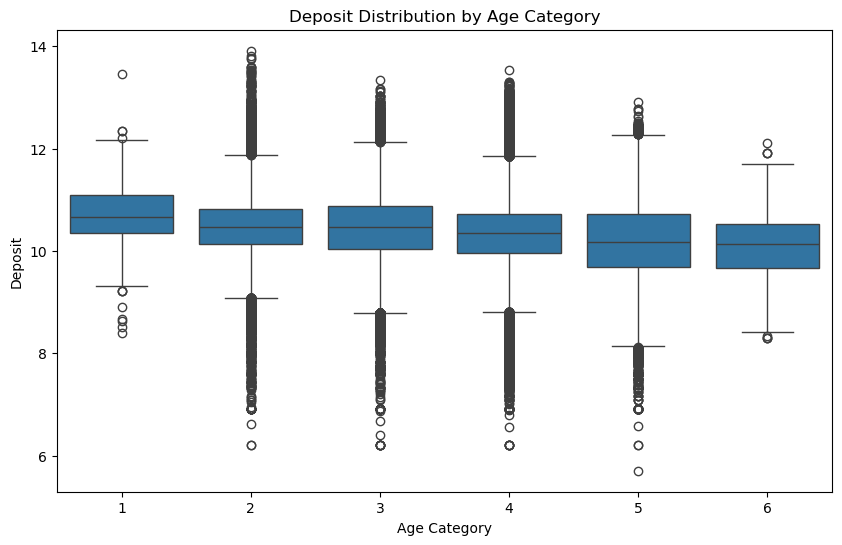

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 박스플롯으로 age_category별 deposit 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_category', y='log_deposit', data=data)
plt.title('Deposit Distribution by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Deposit')
plt.show()


In [16]:
data[['apt_idx','log_deposit']].corr()

,apt_idx,log_deposit
apt_idx,1.000000,0.200327
log_deposit,0.200327,1.000000


In [13]:
apt_idx = data.groupby('apt_idx')['log_deposit'].mean()

In [14]:
apt_idx

apt_idx
0        10.366520
1         8.464513
2         8.417126
3         9.990129
4         8.395974
           ...    
18671          NaN
18672          NaN
18673          NaN
18674          NaN
18675          NaN
Name: log_deposit, Length: 18676, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 고유한 apt_idx 목록 가져오기
apt_indices = data['apt_idx'].unique()

# tqdm 적용하여 진행 상태 표시
for idx in tqdm(apt_indices, desc="Plotting apt_idx categories"):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='age_category', y='log_deposit', data=data[data['apt_idx'] == idx])
    plt.title(f'Deposit Distribution for apt_idx {idx}')
    plt.xlabel('Age Category')
    plt.ylabel('Log Deposit')
    plt.show()


---

# data 컬럼 확인

In [31]:
data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day', 'floor',
       'built_year', 'latitude', 'longitude', 'age', 'deposit', '_type',
       'apt_idx', 'area', 'area_price', 'area_m2_price', 'grid_id',
       'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate', 'contract_0',
  

---

# XGBoost 모델 학습

In [34]:
train_data = data[data['_type'] == 'train']
test_data = data[data['_type'] == 'test']

In [35]:
column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index', 'contract_type','contract_year_month', 'contract_day',
    'area_m2', 
    'contract_date_numeric',
    'floor', 'built_year', 'latitude', 'longitude', 
    'age',
    'contract_0', 'contract_1',
    'deposit',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    'nearest_elementary_school_distance',
    'nearest_middle_school_distance',
    'nearest_high_school_distance',
    'nearest_park_distance',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit',
    'nearest_park_idx',
    'nearest_school_idx',
    'nearest_school_distance',
    # 'Level_elementary','Level_high','Level_middle',
    'park_area',
    # 'age_Future', 'age_New', 'age_Recent', 'age_Old', 'age_Very Old',
]
test_column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index','deposit', 'contract_type','contract_year_month', 'contract_day',
    'area_m2', 
    'contract_date_numeric',
    'floor', 'built_year', 'latitude', 'longitude', 
    'age',
    'contract_0', 'contract_1',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    'nearest_elementary_school_distance',
    'nearest_middle_school_distance',
    'nearest_high_school_distance',
    'nearest_park_distance',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit',
    'nearest_park_idx',
    'nearest_school_idx',
    'nearest_school_distance',
    # 'Level_elementary','Level_high','Level_middle',
    'park_area',
    # 'age_Future', 'age_New', 'age_Recent', 'age_Old', 'age_Very Old',
]
train_df = train_data[column_needed]
test_df = test_data[test_column_needed]

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# # 학습에 사용할 특징 열
# feature_columns = [col for col in data.columns if col not in ['deposit', '_type', 'index']]
# 학습 및 테스트 데이터 준비
X_train = train_df.drop(columns=['deposit'])
y_train = train_df['deposit']
X_test = test_df.copy()
# 학습 데이터를 검증용으로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2,
                                                                          random_state=42)
# XGBoost를 위한 DMatrix 생성
dtrain = xgb.DMatrix(X_train_split, label=y_train_split)
dval = xgb.DMatrix(X_val_split, label=y_val_split)
dtest = xgb.DMatrix(X_test)
# XGBoost 파라미터 설정
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
# 모델 학습
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=50, evals=evals, verbose_eval=10)
# 테스트 세트에 대한 예측
y_pred = model.predict(dtest)

[0]	train-mae:16597.95719	eval-mae:16599.15132
[10]	train-mae:11567.69622	eval-mae:11569.98443
[20]	train-mae:8608.30037	eval-mae:8609.39780
[30]	train-mae:7146.53808	eval-mae:7143.59990
[40]	train-mae:6273.40083	eval-mae:6269.63455
[50]	train-mae:5789.06167	eval-mae:5788.47547
[60]	train-mae:5540.07913	eval-mae:5541.59533
[70]	train-mae:5405.79829	eval-mae:5408.61092
[80]	train-mae:5316.22020	eval-mae:5321.07941
[90]	train-mae:5255.46997	eval-mae:5261.80488
[100]	train-mae:5207.95003	eval-mae:5215.13882
[110]	train-mae:5168.24227	eval-mae:5175.96347
[120]	train-mae:5136.89114	eval-mae:5145.48798
[130]	train-mae:5108.32907	eval-mae:5117.64174
[140]	train-mae:5082.91110	eval-mae:5092.47280
[150]	train-mae:5063.54026	eval-mae:5073.76098
[160]	train-mae:5044.00716	eval-mae:5054.89712
[170]	train-mae:5023.70316	eval-mae:5035.25772
[180]	train-mae:5011.72677	eval-mae:5023.85735
[190]	train-mae:4994.17804	eval-mae:5007.04565
[200]	train-mae:4976.22690	eval-mae:4989.87234
[210]	train-mae:4962

KeyboardInterrupt: 

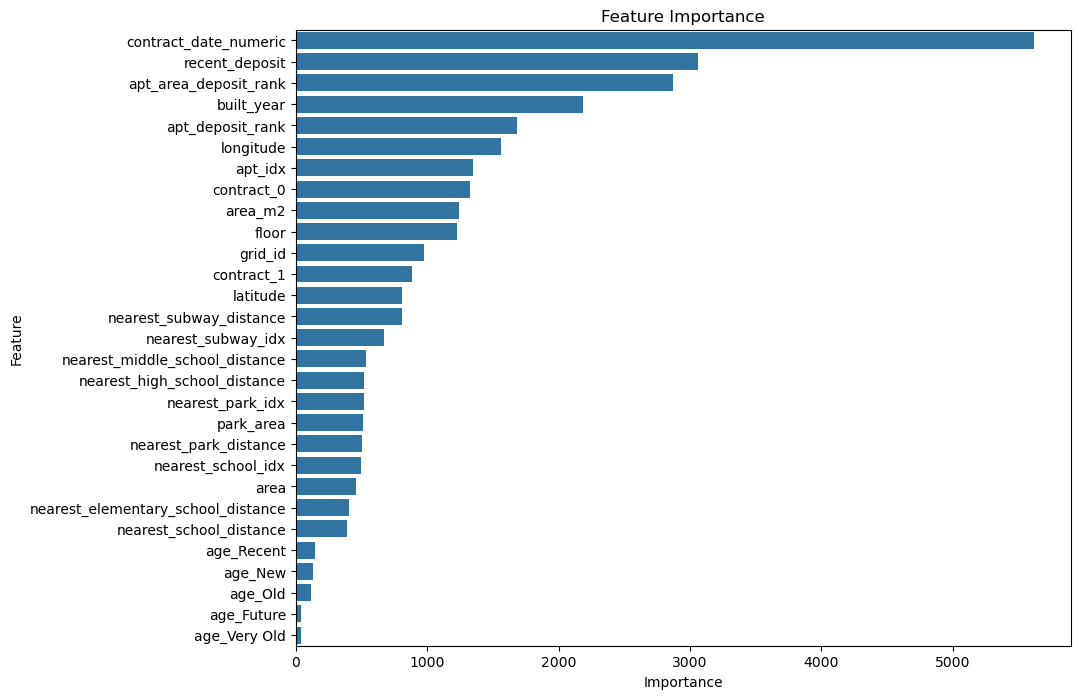

In [83]:
#Feature Importance
# 피처 중요도 추출
feature_importance = model.get_fscore()
# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])
# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [70]:
y_pred

array([22520.906 ,  7745.3193,  6831.748 , ..., 45217.89  , 36463.76  ,
       37792.14  ], dtype=float32)

In [71]:
sample_submission['deposit'] = y_pred
sample_submission

,index,deposit
0,0,22520.906250
1,1,7745.319336
2,2,6831.748047
3,3,6952.722656
4,4,7075.594727
...,...,...
150167,150167,37225.773438
150168,150168,43696.187500
150169,150169,45217.890625
150170,150170,36463.761719


In [72]:
sample_submission.describe()

,index,deposit
count,150172.00000,150172.000000
mean,75085.50000,38833.625000
std,43351.06665,23591.417969
min,0.00000,3369.640381
25%,37542.75000,23120.084473
50%,75085.50000,33781.167969
75%,112628.25000,47944.565430
max,150171.00000,364179.875000


In [66]:
sample_submission.to_csv('v4_add(school_park_idx_area).csv', index=False)

---

In [73]:
data['interest_rate']

0          1.78
1          1.26
2          1.26
3          1.68
4          1.85
           ... 
1951395    3.62
1951396    3.59
1951397    3.59
1951398    3.59
1951399    3.59
Name: interest_rate, Length: 1951400, dtype: float64

In [74]:
interest = pd.read_csv(os.path.join(BASE_PATH, 'interestRate.csv'))

In [75]:
interest

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66
...,...,...
61,201904,1.85
62,201903,1.94
63,201902,1.92
64,201901,1.99


---

In [31]:
data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day', 'floor',
       'built_year', 'latitude', 'longitude', 'age', 'deposit', '_type',
       'apt_idx', 'area', 'area_price', 'area_m2_price', 'grid_id',
       'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate', 'contract_0',
  

In [1]:
df.isnull().sum()

NameError: name 'df' is not defined

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler


# 데이터 로딩 및 전처리
# 계약일을 기준으로 데이터를 정렬하고, 순차적인 데이터를 만들기 위해 그룹화할 수 있음
# 청크 단위로 데이터 처리 (예시: CSV에서 읽어오는 경우)
# 필요한 열만 선택해서 작업
columns_to_use = ['contract_year_month', 'contract_day', 'interest_rate', 'recent_deposit', '_type',
                  'latitude', 'longitude', 'area_m2', 'floor', 'age','contract_date','deposit']

df = data[columns_to_use].sort_values(by=['contract_date'])

# 타겟 변수와 특성 선택 (예: contract_date, interest_rate 등 순차적 데이터 활용)
features = [
    'contract_year_month', 'contract_day', 'interest_rate','recent_deposit',
    'latitude', 'longitude','area_m2', 'floor', 'age',
]
target = 'deposit'

# _type 열을 사용해 train과 test 데이터를 구분
train_data = df[df['_type'] == 'train']
test_data = df[df['_type'] == 'test']

# Train 데이터에서 특성과 타겟 변수 분리
X_train = train_data[features].values
y_train = train_data[target].values

# Test 데이터에서 특성과 타겟 변수 분리
X_test = test_data[features].values
y_test = test_data[target].values  # 만약 타겟이 있다면

# 데이터 정규화 (GRU 모델에서는 정규화가 중요)
scaler = MinMaxScaler()

# Train 데이터 정규화
X_train_scaled = scaler.fit_transform(X_train)

# Test 데이터 정규화
X_test_scaled = scaler.transform(X_test)

# 데이터를 시계열 형태로 변환 (예: 윈도우 크기 10의 시계열 데이터를 사용)
def create_sequences(data, target, window_size):
    Xs, ys = [], []
    for i in range(len(data) - window_size):
        Xs.append(data[i:i + window_size])
        ys.append(target[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, window_size)

# GRU 모델 구성
model = Sequential()
model.add(GRU(units=64, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dense(1))  # 출력층 (전세가 예측)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq))

# 예측
predictions = model.predict(X_test_seq)

# 결과 평가
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_seq, predictions)
print(f'Mean Squared Error: {mse}')

c:\Users\com\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 184s 3ms/step - loss: nan - val_loss: nan
Epoch 2/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 168s 3ms/step - loss: nan - val_loss: nan
Epoch 3/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 191s 3ms/step - loss: nan - val_loss: nan
Epoch 4/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 183s 3ms/step - loss: nan - val_loss: nan
Epoch 5/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 173s 3ms/step - loss: nan - val_loss: nan
Epoch 6/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 192s 3ms/step - loss: nan - val_loss: nan
Epoch 7/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 186s 3ms/step - loss: nan - val_loss: nan
Epoch 8/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 180s 3ms/step - loss: nan - val_loss: nan
Epoch 9/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 179s 3ms/step - loss: nan - val_loss: nan
Epoch 10/10
56289/56289 ━━━━━━━━━━━━━━━━━━━━ 183s 3ms/step - loss: nan - val_loss: nan
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


ValueError: Input contains NaN.